# SDA

In [1]:
import math
import rbo
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Self

import numpy as np
import pandas as pd

In [2]:
def gen_send_behaviors(N_users, N_friends=None, self_rec=False, p_sender=1):
    if N_friends is None:
        N_friends = N_users

    send_behaviors = []
    for _ in range(N_users):
        if p_sender is not None and np.random.random() <= p_sender:
            n_friends = np.random.randint(1, N_friends+1)
        else:
            n_friends = 0
        behavior = np.random.random(n_friends)
        behavior = np.append(behavior, np.zeros(N_users-n_friends))
        np.random.shuffle(behavior)
        send_behaviors.append(behavior)
        
    send_behaviors = np.asarray(send_behaviors)
    if not self_rec:
        send_behaviors[np.diag_indices(n=N_users)] = 0
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        send_behaviors = send_behaviors / send_behaviors.sum(axis=1)[:, np.newaxis]
    send_behaviors[np.isnan(send_behaviors)] = 0
    return send_behaviors


def gen_messages_uniform(send_behaviors, K_rounds, batch_size):
    N_users = send_behaviors.shape[0]
    actual_sender = np.where(send_behaviors.any(axis=1))[0]

    N_messages = K_rounds * batch_size
    senders = np.random.choice(actual_sender, size=N_messages)
    receivers = [np.random.choice(range(N_users), p=send_behaviors[i]) for i in senders]
    
    return senders.reshape(-1, batch_size), np.asarray(receivers).reshape(-1, batch_size)


def gen_messages_normal(send_behaviors, K_rounds, batch_size):
    N_users = send_behaviors.shape[0]
    actual_sender = np.where(send_behaviors.any(axis=1))[0]

    senders = np.asarray([np.random.normal(i, scale=len(actual_sender)/6, size=batch_size).round(0) % len(actual_sender)
                              for i in range(K_rounds)]).astype(int)
    senders = actual_sender[senders]
    
    receivers = [np.random.choice(range(N_users), p=send_behaviors[i]) for i in senders.reshape(-1)]
    return senders, np.asarray(receivers).reshape(-1, batch_size)

In [3]:
N_users = 100
N_friends = 10
K_rounds = 1000
batch_size = 10
np.random.seed(42)
send_behaviors = gen_send_behaviors(N_users, N_friends, p_sender=0.8)
sender_list, receiver_list = gen_messages_uniform(send_behaviors, K_rounds, batch_size)
actual_senders = np.unique(sender_list.reshape(-1))
print("Actual senders:", actual_senders.size)

Actual senders: 83


<Axes: title={'center': 'Sender uniform distribution'}>

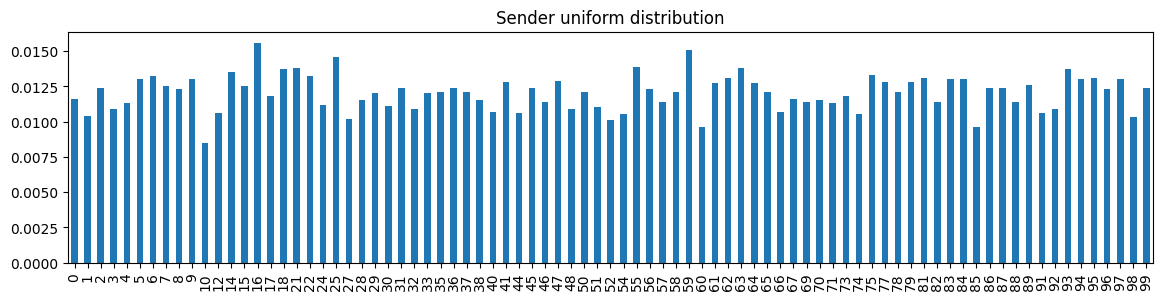

In [4]:
pd.Series(sender_list.reshape(-1)).value_counts(normalize=True, sort=False).sort_index().plot.bar(figsize=(14, 3), title="Sender uniform distribution")

Text(0.5, 1.0, 'Sender uniform distribution')

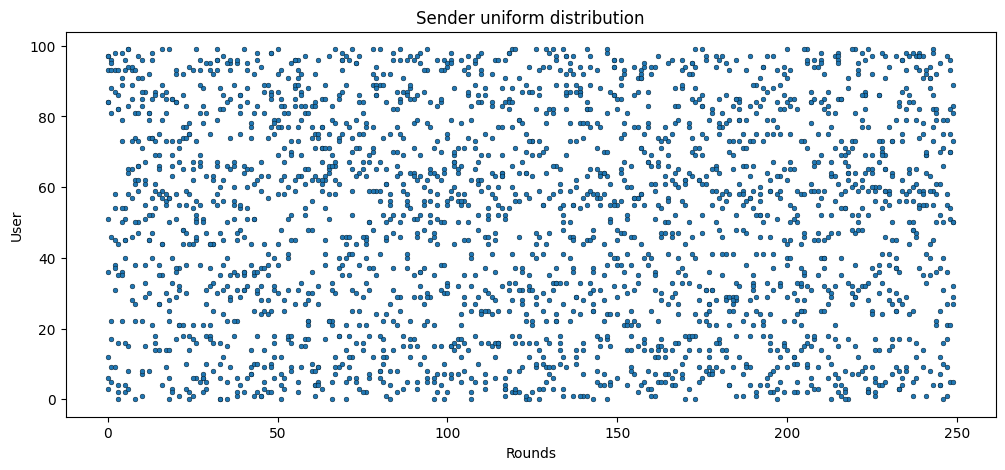

In [5]:
color = sns.color_palette()[0]
fig, ax = plt.subplots(figsize=(12, 5))
pd.DataFrame(sender_list).iloc[:250].apply(lambda col: sns.scatterplot(x=col.index, y=col.values, ax=ax, edgecolor = "black", color=color, s=12))
ax.set_xlabel("Rounds")
ax.set_ylabel("User")
ax.set_title("Sender uniform distribution")

In [6]:
def entropy(probabilities):
    return -sum([p*math.log(p, 2) if p > 0 else 0 for p in probabilities])

def norm_entropy(probabilities):
    return entropy(probabilities) / np.log2(probabilities.size)

def entropy_target(target_user):
    rounds_target = np.where(sender_list == target_user)[0]
    observations_target = receiver_list[rounds_target]
    probabilities = np.bincount(observations_target.reshape(-1), minlength=N_users) / observations_target.size
    return norm_entropy(probabilities)

print("Mean entropy for actual senders", np.mean([entropy_target(u) for u in actual_senders]))

Mean entropy for actual senders 0.9291295543814868


In [11]:
rounds_target = np.where(sender_list == target_user)[0]
observations_target = receiver_list[rounds_target]
np.bincount(observations_target.reshape(-1), minlength=N_users)

array([10,  9, 24, 12, 19,  0, 13,  0,  9,  4, 10,  4, 16, 18, 12,  1,  4,
       13, 12,  4, 13,  1,  8, 14,  0, 13, 14, 80,  7,  8, 23,  7, 11, 20,
       13, 26, 21,  3,  6, 11, 20,  7, 13, 45, 14,  0,  8,  6, 17, 15, 16,
        2,  9, 13, 19,  2, 11, 13,  3,  4,  9, 16,  7,  6,  3,  3, 10, 11,
        4, 13, 15,  1,  6,  4, 11, 10, 13,  1,  0, 43, 17, 15,  2, 66, 14,
       27, 13,  9, 24, 14, 51, 21, 25, 11, 14,  7, 26, 13,  3, 12])

In [8]:
target_user = sender_list[0][0]
print(f"Target user = {target_user}")
target_behavior = send_behaviors[target_user]
target_rank = target_behavior.argsort()[::-1]
target_friends = target_rank[:np.where(target_behavior > 0)[0].size]
#print("Target behavior", target_behavior.round(3))
#print("Target rank", target_rank)
print("Target friends", target_friends)

Target user = 97
Target friends [83 27 90 96 44]


In [7]:
def sda(n_users, receiver_list, sender_list=None, target_user=None, limit=None):
    if sender_list is not None and target_user is not None:
        rounds_target = np.where(sender_list == target_user)[0]
        observations_target = receiver_list[rounds_target]
    else:
        observations_target = receiver_list

    if limit is not None:
        observations_target = observations_target[:limit]  

    batch_size = sender_list.shape[1]
    freqs = np.bincount(observations_target.reshape(-1), minlength=n_users)
    noise = np.full(freqs.size, 1/freqs.size)
    target_prop = freqs / freqs.size - (batch_size - 1)*noise
    return target_prop, target_prop.argsort()[::-1]

def sda_random(n_users, receiver_list, sender_list=None, target_user=None, limit=None):
    if sender_list is not None and target_user is not None:
        rounds_target = np.where(sender_list == target_user)[0]
        observations_target = receiver_list[rounds_target]
    else:
        observations_target = receiver_list

    if limit is not None:
        observations_target = observations_target[:limit]

    senders = np.unique(observations_target.reshape(-1))
    target_prop = np.zeros(n_users)
    target_prop[senders] = np.random.random(len(senders))
    return target_prop, target_prop.argsort()[::-1]

def sda_count(n_users, receiver_list, sender_list=None, target_user=None, limit=None):
    if sender_list is not None and target_user is not None:
        rounds_target = np.where(sender_list == target_user)[0]
        observations_target = receiver_list[rounds_target]
    else:
        observations_target = receiver_list

    if limit is not None:
        observations_target = observations_target[:limit]

    target_prop = np.bincount(observations_target.reshape(-1), minlength=n_users) / observations_target.sum()
    return target_prop, target_prop.argsort()[::-1]

def get_cosender_behavior(n_users, receiver_list, sender_list, cosender):
    rounds_cosender = np.where(sender_list == cosender)[0]
    observations_cosender = receiver_list[rounds_cosender]
    behavior_cosender = np.bincount(observations_cosender.reshape(-1), minlength=n_users)
    return behavior_cosender / behavior_cosender.sum()

def sda_sn(n_users, receiver_list, sender_list, target_user, limit=None):
    rounds_target = np.where(sender_list == target_user)[0]
    observations_target = receiver_list[rounds_target]
    senders_target = sender_list[rounds_target]

    if limit is not None:
        observations_target = observations_target[:limit]
        senders_target = senders_target[:limit] 

    batch_size = sender_list.shape[1]
    freqs = np.bincount(observations_target.reshape(-1), minlength=n_users)
    
    cosenders = list(set(senders_target.reshape(-1)) - {target_user})
    weights_cosender = np.bincount(senders_target.reshape(-1))
    weights_cosender[target_user] = 0
    weights_cosender = weights_cosender / weights_cosender.sum()
    behaviors_cosender = np.zeros((weights_cosender.size, n_users))
    behaviors_cosender[cosenders] = np.asarray([get_cosender_behavior(n_users, receiver_list, sender_list, cosender)
                                                for cosender in cosenders])
    weights_cosender = np.expand_dims(weights_cosender, 0)
    noise = np.matmul(weights_cosender, behaviors_cosender).squeeze()
    
    target_prop = freqs / freqs.size - (batch_size - 1)*noise
    return target_prop, target_prop.argsort()[::-1]
    

results = {}
for fn_attack in [sda, sda_random, sda_count, sda_sn]:
    params = (N_users, receiver_list, sender_list, target_user)
    name = fn_attack.__name__
    results[name] = fn_attack(*params)

In [8]:
def evaluate(target_friends, estimated_ranks):
    results = {}
    estimated_frieds = estimated_ranks[:len(target_friends)]
    results['rbo'] = rbo.RankingSimilarity(target_friends, estimated_frieds).rbo()
    results['%friends'] = len(set(target_friends).intersection(estimated_frieds)) / len(target_friends)
    estimated_ranks = estimated_ranks.tolist()
    results['mae'] = sum([abs(f_i - estimated_ranks.index(f_v)) for f_i, f_v in enumerate(target_friends)]) / len(target_friends)
    return results

performances = {name: evaluate(target_friends, result[1]) for name, result in results.items()}
performances

{'sda': {'rbo': 0.67, '%friends': 0.6, 'mae': 6.4},
 'sda_random': {'rbo': 0.0, '%friends': 0.0, 'mae': 59.4},
 'sda_count': {'rbo': 0.67, '%friends': 0.6, 'mae': 6.4},
 'sda_sn': {'rbo': 0.67, '%friends': 0.6, 'mae': 6.8}}

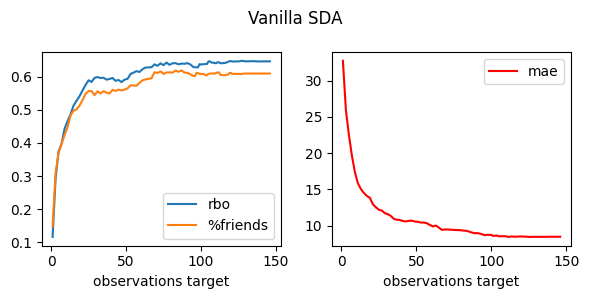

In [9]:
def attack_sda_user(fn_attack, n_users, send_behaviors, sender_list, target_user, p_obs=0.002, **kwargs):
    target_behavior = send_behaviors[target_user]
    target_rank = target_behavior.argsort()[::-1]
    target_friends = target_rank[:np.where(target_behavior > 0)[0].size]

    k_rounds = sender_list.shape[0]
    rounds_target = len(set(np.where(sender_list == target_user)[0]))
    n_obs = list(range(1, rounds_target+1, math.ceil(k_rounds*p_obs)))
    if n_obs[-1] != rounds_target:
        n_obs.append(rounds_target)
    results = [fn_attack(n_users=n_users, target_user=target_user, limit=k_obs, sender_list=sender_list, **kwargs)[1] for k_obs in n_obs]
    performance = pd.DataFrame([evaluate(target_friends, result) for result in results], index=n_obs)
    performance.index.name = "observations target"
    return performance

def attack_sda(fn_attack, n_users, send_behaviors, sender_list, **kwargs):
    senders = np.unique(sender_list.reshape(-1))
    dfs = [attack_sda_user(fn_attack, n_users, send_behaviors, sender_list, sender, **kwargs) for sender in senders]
    df_tmp = pd.concat(dfs, axis=1).sort_index().ffill()
    df = pd.DataFrame()
    for col in df_tmp.columns.unique():
        df[col] = df_tmp[col].mean(axis=1)
    return df

df_sda = attack_sda(sda, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("Vanilla SDA")
df_sda[['rbo', '%friends']].plot(ax=axs[0])
df_sda[['mae']].plot(ax=axs[1], c='r')
fig.tight_layout()

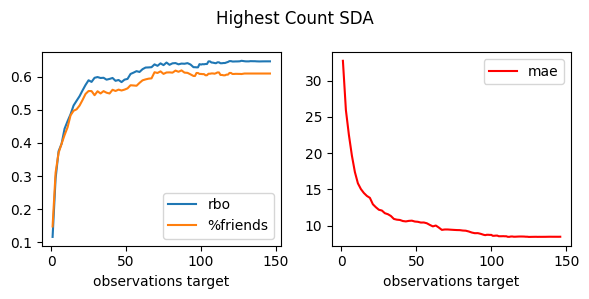

In [36]:
df_sda_count = attack_sda(sda_count, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("Highest Count SDA")
df_sda_count[['rbo', '%friends']].plot(ax=axs[0])
df_sda_count[['mae']].plot(ax=axs[1], c='r')
fig.tight_layout()

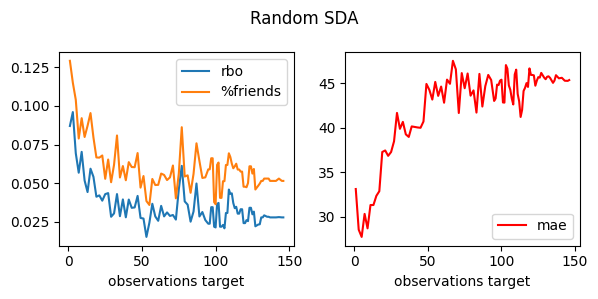

In [37]:
df_sda_random = attack_sda(sda_random, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("Random SDA")
df_sda_random[['rbo', '%friends']].plot(ax=axs[0])
df_sda_random[['mae']].plot(ax=axs[1], c='r')
fig.tight_layout()

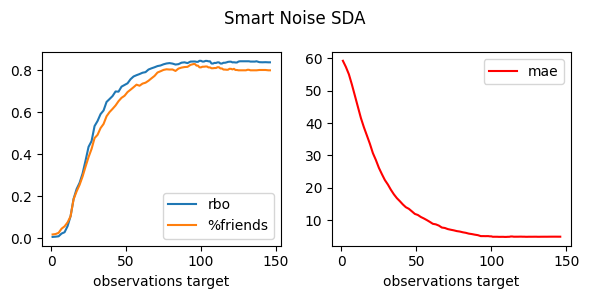

In [38]:
df_sda_sn = attack_sda(sda_sn, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("Smart Noise SDA")
df_sda_sn[['rbo', '%friends']].plot(ax=axs[0])
df_sda_sn[['mae']].plot(ax=axs[1], c='r')
fig.tight_layout()

In [39]:
dfs_uniform = {'Vanilla SDA': df_sda, 'Random SDA': df_sda_random, 'Smart Noise SDA': df_sda_sn}

## Messages drawn from Normal distribution

In [34]:
sender_list, receiver_list = gen_messages_normal(send_behaviors, K_rounds, batch_size)

<Axes: title={'center': 'Sender normal distribution'}>

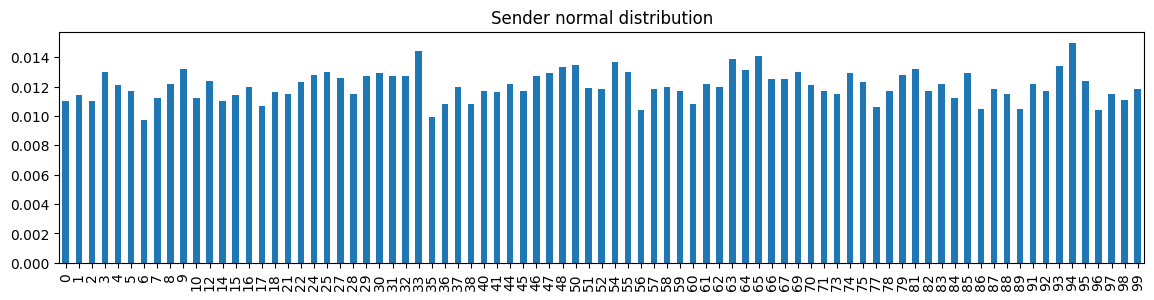

In [35]:
pd.Series(sender_list.reshape(-1)).value_counts(normalize=True, sort=False).sort_index().plot.bar(figsize=(14, 3), title="Sender normal distribution")

Text(0, 0.5, 'User')

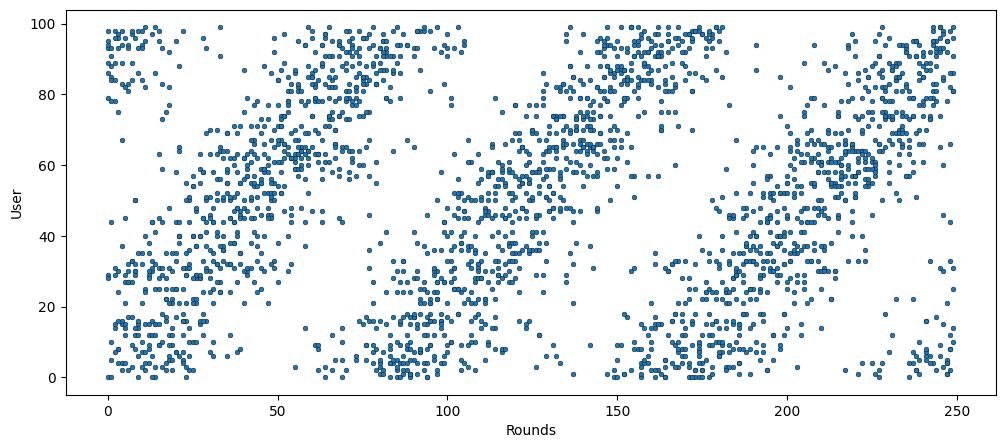

In [36]:
color = sns.color_palette()[0]
fig, ax = plt.subplots(figsize=(12, 5))
pd.DataFrame(sender_list).iloc[:250].apply(lambda col: sns.scatterplot(x=col.index, y=col.values, ax=ax, edgecolor = "black", color=color, s=12))
ax.set_xlabel("Rounds")
ax.set_ylabel("User")

In [43]:
df_sda = attack_sda(sda, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)
df_sda_random = attack_sda(sda_random, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)
df_sda_count = attack_sda(sda_count, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)
df_sda_sn = attack_sda(sda_sn, N_users, send_behaviors, sender_list=sender_list, receiver_list=receiver_list)

dfs_normal = {'Vanilla SDA': df_sda, 'Random SDA': df_sda_random, 'Smart Noise SDA': df_sda_sn}

In [44]:
dfs_all = {'uniform': dfs_uniform, 'normal': dfs_normal}

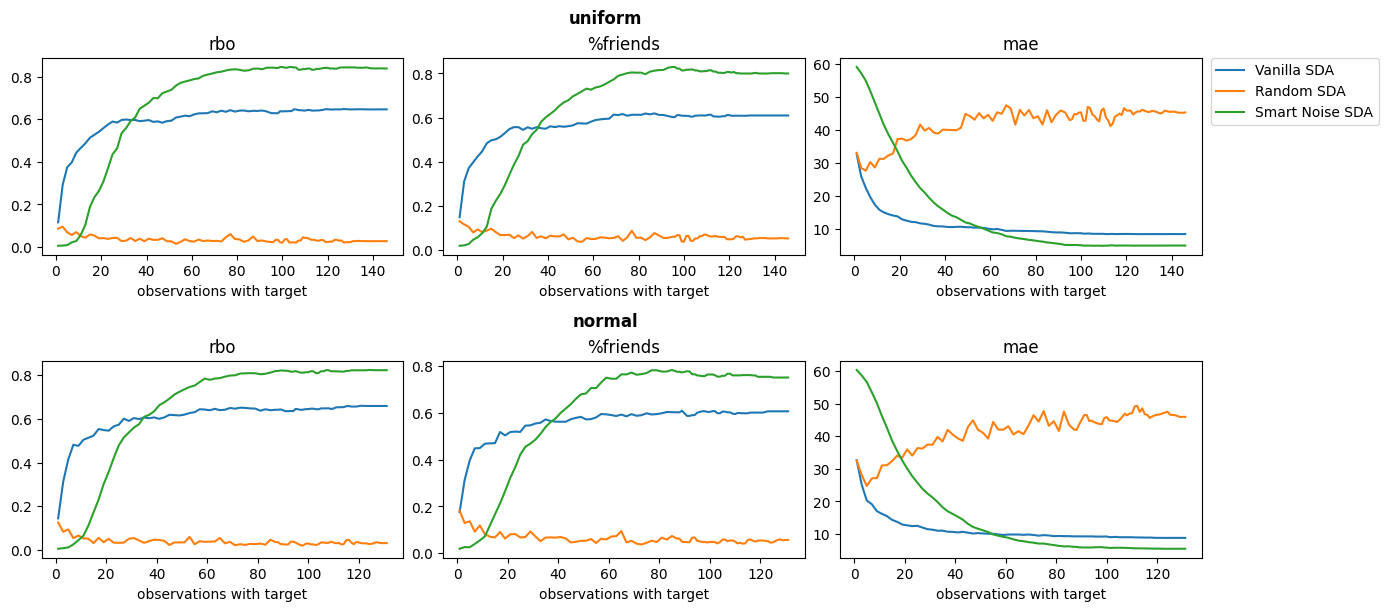

In [45]:
fig = plt.figure(constrained_layout=True, figsize=(12,6))
subfigs = fig.subfigures(nrows=len(dfs_all), ncols=1)

cols = list(df_sda.columns)
for i, (subfig, (sub_title, dfs)) in enumerate(zip(subfigs, dfs_all.items())):
    subfig.suptitle(sub_title, fontweight='bold')
    axs = subfig.subplots(1, len(cols))
    for j, (col, ax) in enumerate(zip(cols, axs)):
        ax.set_title(col)
        ax.set_xlabel("observations with target")
        for name, df in dfs.items():
            if i == 0 and j == 0:
                ax.plot(df.index, df[col], label=name)
            else:
                ax.plot(df.index, df[col])
        #ax.legend()

#fig.tight_layout()
fig.legend(loc='center right', bbox_to_anchor=(1.15,0.856), bbox_transform=fig.transFigure)
fig.savefig('results.svg')

## Example SDA from file

In [52]:
class Dataset:

    def __init__(self, sender_list: np.ndarray, receiver_list: np.ndarray, send_behaviors: np.ndarray | None = None) -> None:
        if sender_list.shape != receiver_list.shape:
            raise ValueError(f"sender_list shape ({sender_list.shape}) must match receiver list shape {receiver_list.shape}")
            
        self.sender_list = sender_list
        self.receiver_list = receiver_list
        self.N_users = len(np.unique(np.vstack([sender_list, receiver_list])))
        self.K_rounds = sender_list.shape[0]
        self.batch_size = sender_list.shape[1]
        self.actual_senders = np.unique(sender_list.reshape(-1))
        self.send_behaviors = send_behaviors

def load_dataset(path: str) -> Dataset:
    sender_list = []
    receiver_list = []
    with open(path) as f:
        for l in f.readlines():
            sender, receiver = l.strip().split(':')
            sender_list.append(np.fromstring(sender, dtype=int, sep=' '))
            receiver_list.append(np.fromstring(receiver, dtype=int, sep=' '))
            
    return Dataset(np.asarray(sender_list), np.asarray(receiver_list))

dataset = load_dataset('observation_mix.txt')

In [59]:
for target in range(1, dataset.N_users+1):
    print(sda(dataset.N_users, dataset.receiver_list, dataset.sender_list, target_user=target)[0].round(3))

[-2.73000e-01  2.63364e+02  2.16455e+02  5.12091e+02  2.17909e+02
  3.74909e+02  7.44550e+01  2.65727e+02  2.16818e+02  3.75636e+02
  4.37727e+02]
[-2.73000e-01  2.50364e+02  2.14727e+02  3.76818e+02  9.30000e+01
  3.55545e+02  7.33640e+01  4.28455e+02  3.67364e+02  2.48818e+02
  4.68091e+02]
[-2.73000e-01  2.55273e+02  2.16091e+02  3.75727e+02  1.69455e+02
  4.26091e+02  1.39182e+02  3.37545e+02  2.78727e+02  3.16091e+02
  3.81636e+02]
[-2.73000e-01  3.85455e+02  2.15000e+02  3.87636e+02  9.62730e+01
  4.87000e+02  7.21820e+01  2.71545e+02  2.18727e+02  3.89091e+02
  4.26364e+02]
[-2.73000e-01  3.39455e+02  2.17182e+02  4.60636e+02  9.67270e+01
  4.33909e+02  1.51091e+02  2.57000e+02  2.87091e+02  2.51818e+02
  3.84545e+02]
[-2.73000e-01  2.61000e+02  2.17000e+02  6.30273e+02  9.71820e+01
  6.18000e+02  7.34550e+01  2.70000e+02  2.16636e+02  2.56273e+02
  3.15636e+02]
[-2.73000e-01  4.91000e+02  4.54000e+02  3.73091e+02  9.50000e+01
  3.46818e+02  7.44550e+01  2.63636e+02  2.07909e+02

# ML

In [16]:
import torch
from torch import nn
from torch import optim

In [17]:
def featureize(sender_list, receiver_list, send_behaviors):
    n_users = send_behaviors.shape[0]
    actual_senders = np.unique(sender_list.reshape(-1))
    
    sender_list_enc = np.apply_along_axis(lambda x: np.bincount(x, minlength=n_users), axis=1, arr=sender_list)
    receiver_list_enc = np.apply_along_axis(lambda x: np.bincount(x, minlength=n_users), axis=1, arr=receiver_list)

    X_senders = []
    X_receivers = []
    y = torch.tensor(send_behaviors[actual_senders], dtype=torch.float32)
    for target_user in actual_senders:
        round_target = np.where(sender_list == target_user)[0]
        X_senders.append(torch.tensor(sender_list_enc[round_target], dtype=torch.float32))
        X_receivers.append(torch.tensor(receiver_list_enc[round_target], dtype=torch.float32))

    return list(zip(X_senders, X_receivers)), y

X_train, y_train = featureize(sender_list, receiver_list, send_behaviors)

In [18]:
class EasyRNN(nn.Module):
    def __init__(self, n_users):
        super(EasyRNN, self).__init__()
        self.gru_sender = nn.GRU(input_size=n_users, hidden_size=n_users)
        self.gru_receiver = nn.GRU(input_size=n_users, hidden_size=n_users)
        self.lin = nn.Linear(n_users, n_users)

    def forward(self, *inputs):
        x_sender, x_receiver = inputs
        #h_sender, _ = self.gru_sender(x_sender)
        h_receiver, _ = self.gru_receiver(x_receiver)
        #h = torch.cat((h_sender[-1], h_receiver[-1]))
        h = h_receiver[-1]
        return self.lin(h)

model = EasyRNN(N_users)

In [19]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
n_epochs = 20
model.train()
for epoch in range(n_epochs):
    for x, y in zip(X_train, y_train):
        y_pred = model(*x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [21]:
send_behaviors = get_send_behaviors(N_users, N_friends, self_rec=True, p_sender=1)
sender_list, receiver_list = get_messages_normal(send_behaviors, K_rounds, batch_size)
actual_senders = np.unique(sender_list.reshape(-1))
X_test, y_test = featureize(sender_list, receiver_list, send_behaviors)

In [22]:
model.eval()
performances = []
for x, y in zip(X_test, y_test):
    target_behavior = y.numpy()
    target_rank = target_behavior.argsort()[::-1]
    target_friends = target_rank[:np.where(target_behavior > 0)[0].size]
    y_pred = model(*x).argsort(descending=True).numpy()
    performances.append(evaluate(target_friends, y_pred))

df_ml = pd.DataFrame(performances)
df_ml

,rbo,jaccard,%friends,mae
0,0.062500,0.75,0.250000,16.750000
1,0.000000,1.00,0.000000,70.500000
2,0.000000,1.00,0.000000,54.333333
3,0.202897,1.00,0.200000,36.400000
4,0.000000,1.00,0.000000,45.875000
...,...,...,...,...
95,0.186111,1.00,0.333333,25.333333
96,0.047897,1.00,0.100000,42.100000
97,0.000000,1.00,0.000000,46.333333
98,0.088889,1.00,0.333333,26.500000


In [23]:
df_ml.mean()

rbo          0.068903
jaccard      0.967083
%friends     0.088643
mae         40.403794
dtype: float64